# Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write your Algorithm
* [Step 6](#step6): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

Make sure that you've downloaded the required human and dog datasets:
* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).  Unzip the folder and place it in this project's home directory, at the location `/dogImages`. 

* Download the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip).  Unzip the folder and place it in the home diretcory, at location `/lfw`.  

*Note: If you are using a Windows machine, you are encouraged to use [7zip](http://www.7-zip.org/) to extract the folder.*

In the code cell below, we save the file paths for both the human (LFW) dataset and dog dataset in the numpy arrays `human_files` and `dog_files`.

In [2]:
import copy
import cv2                
from glob import glob
from io import open
import json
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os, os.path, random
from PIL import Image
import torch
from torch.autograd import Variable
import torch.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms

In [3]:
# load filenames for human and dog images
# transform to np
human_files = np.array(glob("lfw/*/*"))
dog_files = np.array(glob("dogImages/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


<a id='step1'></a>
## Step 1: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.  In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


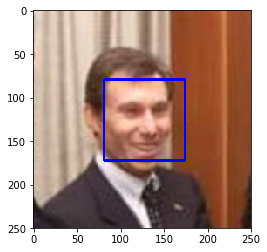

In [4]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
# cv2.CascadeClassifier with frontalface xml
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[0])

# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
# note that face finding is done in the gray image
# cascade.detectMultiScale(img)
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    # cv2.rectangle to make the box on coordinates
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
# now we're plotting an image in colour again
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

In [5]:
# note the (250, 250, 3) input for color images, and (250, 250) for gray
print('Shape of color images: ' + str(cv_rgb.shape))
print('Shape of gray images: ' + str(gray.shape))

Shape of color images: (250, 250, 3)
Shape of gray images: (250, 250)


Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [6]:
# returns "True" if face is detected in image stored at img_path
# simple face detector based on haar cascade --> detectMultiScale

def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray) # cascade.detectMultiScale
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer RTW:__ 

In 100 human pictures, 99 faces are detected.
In 100 doc pictures, 18 faces are detected. 

Note that this may change slightly if you run the code multiple times.

In [7]:
from tqdm import tqdm # to show progress bar, not used

human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

#-#-# Do NOT modify the code above this line. #-#-#

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
human_faces = np.sum([face_detector(i) for i in human_files_short])
dog_faces = np.sum([face_detector(i) for i in dog_files_short])

print('Amount of human faces detected: ', format(human_faces))
print('Human faces detected in dogs dataset: ', format(dog_faces))

Amount of human faces detected:  99
Human faces detected in dogs dataset:  18


We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 and ResNet Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [8]:
import torch
import torchvision.models as models # model imported from torchvision 

# define VGG16 model trained on Imagenet (1000 categories and 10M pictures)
VGG16 = models.vgg16(pretrained=True) # pretrained

# check if CUDA is available
# CUDA not available since training on CPU
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()

# check if cuda is available (takes a while)
print(torch.cuda.is_available())

False


In [10]:
# checkout the model layers
# note the 30 feature layers followed by 6 layers to classify
print(VGG16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [11]:
# check out the final classifier layer to change
# model trained on Imagenet, so 1000 classes now
print(VGG16.classifier[6])

Linear(in_features=4096, out_features=1000, bias=True)


Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### (IMPLEMENTATION) Making Predictions with a Pre-trained Model

In the next code cell, you will write a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

Before writing the function, make sure that you take the time to learn  how to appropriately pre-process tensors for pre-trained models in the [PyTorch documentation](http://pytorch.org/docs/stable/torchvision/models.html).

In [13]:
# check out current input - 1 (size)
# always know what you're feeding the network
img = cv2.imread(human_files_short[0])
print(img.shape)

(250, 250, 3)


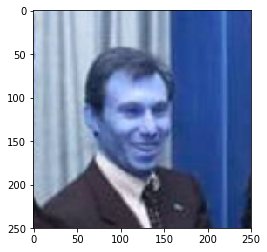

In [14]:
# check out current input - 2
plt.imshow(img)

In [21]:
# transformation for train, test, valid: resize, tensor, normalize
# no grayscale added for now
# normalization added
import torchvision.transforms as transforms

prep_train = transforms.Compose((transforms.RandomResizedCrop(224), 
                                 transforms.ToTensor(), 
                                 transforms.Normalize(mean = [0.5, 0.5, 0.5], std = [0.2, 0.2, 0.2])))

prep_test = transforms.Compose((transforms.Normalize(mean = [0.5, 0.5, 0.5], std = [0.2, 0.2, 0.2]), 
                                transforms.Resize(224),
                                transforms.ToTensor()))

prep_valid = transforms.Compose((transforms.Normalize(mean = [0.5, 0.5, 0.5], std = [0.2, 0.2, 0.2]), 
                                 transforms.Resize(224),
                                 transforms.ToTensor()))

In [15]:
# plan B, go more extensive and include augmentation for the training set
prep2_train = transforms.Compose([
        transforms.Resize(256),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomAffine(degrees=5, translate=(0.1, 0.1), scale=(1.0, 1.1), shear=5, resample=False, fillcolor=0),
        transforms.RandomApply([transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1)], p=0.5),
        transforms.RandomGrayscale(p=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

In [22]:
# feed to the model; technically just model(input)
# include opening of file, transformation of file first

from PIL import Image
import torchvision.transforms as transforms

def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    
    ## TODO: Complete the function.
    ## Load and pre-process an image from the given img_path
    ## Return the *index* of the predicted class for that image
    image = Image.open(img_path)
    image_tensor = prep_train(image).float() # image becomes 224*224 normalized tensor
    
    if use_cuda:
        image_tensor = image_tensor.cuda()
        
    image_final = image_tensor.unsqueeze(0)  
    output = VGG16(image_final)  # just feed the right image format to VGG16
    
    _, preds_tensor = torch.max(output, 1)
    
    class_index = np.squeeze(preds_tensor.numpy()) if not use_cuda else np.squeeze(preds_tensor.cpu().numpy())
    return class_index

### (IMPLEMENTATION) Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

Use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [23]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    ## TODO: Complete the function.
    prediction = VGG16_predict(img_path)
    return ((prediction <= 268) & (prediction >= 151)) # true if both conditions are met

### (IMPLEMENTATION) Assess the Dog Detector

__Question 2:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer RTW:__ 
1/100 humans are miscategorized as dogs &
91/100 dogs were classified correctly as dogs. Not bad for just importing a pre-trained model. Note that prediction changes if you run the cell again.

In [24]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.
## note: output takes a long time if cuda is FALSE

# dog detector needs to accurately find DOGS, not humans
humans_seen_as_dog = sum(dog_detector(i) for i in human_files_short)
dogs_seen_as_dog = sum(dog_detector(i) for i in dog_files_short)

print('Humans miscategorized as dogs: {}'.format(humans_seen_as_dog))
print('Dogs correctly classified as dogs: {}'.format(dogs_seen_as_dog))

Humans miscategorized as dogs: 1
Dogs correctly classified as dogs: 91


We suggest VGG-16 as a potential network to detect dog images in your algorithm, but you are free to explore other pre-trained networks (such as [Inception-v3](http://pytorch.org/docs/master/torchvision/models.html#inception-v3), [ResNet-50](http://pytorch.org/docs/master/torchvision/models.html#id3), etc).  Please use the code cell below to test other pre-trained PyTorch models.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch) 


Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 10%.  In Step 4 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively).  You may find [this documentation on custom datasets](http://pytorch.org/docs/stable/torchvision/datasets.html) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [37]:
import copy
import cv2                
from glob import glob
from io import open
import json
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os, os.path, random
from PIL import Image, ImageFile
import torch
from torch.autograd import Variable
import torch.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms

%matplotlib inline

ImageFile.LOAD_TRUNCATED_IMAGES = True

use_cuda = torch.cuda.is_available()
print('Working on GPU: ', use_cuda)

Working on GPU:  False


In [38]:
# explore the amount of files that we have in all sets before transformation
# get dog train, valid, test files via glob
dog_train_files = np.array(glob("dogImages/train/*/*"))
dog_valid_files = np.array(glob("dogImages/valid/*/*"))
dog_test_files = np.array(glob("dogImages/test/*/*"))

print('Length of the dog train files:', len(dog_train_files))
print('Length of the dog validation files:', len(dog_valid_files))
print('Length of the dog test files:', len(dog_test_files))

Length of the dog train files: 6680
Length of the dog validation files: 835
Length of the dog test files: 836


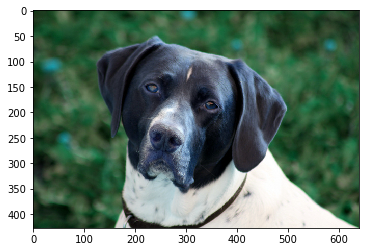

In [44]:
# exloration: check an example
dog_train_test = cv2.imread(dog_train_files[10]) # gives np.array
plt.imshow(dog_train_test)

In [45]:
# test the sisze of the images; note images are not the same size!
dog_train_test.shape

(427, 640, 3)

In [48]:
# write the data loaders for train, valid and test sets
# ensure images all become the same size
# all torch.utils.data.dataloaders are in here now

bs = 12 # training on CPU, guess 
num_workers = 2

# transforms.Compose function
transform = transforms.Compose([transforms.Resize(size=224),
                                transforms.CenterCrop((224,224)),
                                transforms.RandomHorizontalFlip(), 
                                transforms.RandomRotation(10),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.5, 0.5, 0.5], std = [0.2, 0.2, 0.2])])

data_dir = 'dogimages'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), transform)
                  for x in ['train', 'valid', 'test']}
loaders_scratch = {
    x: torch.utils.data.DataLoader(image_datasets[x], shuffle=True, batch_size=bs, num_workers=num_workers)
    for x in ['train', 'valid', 'test']}

In [68]:
# note color --> 3 channels
print(image_datasets['train'])

Dataset ImageFolder
    Number of datapoints: 6680
    Root Location: dogimages/train
    Transforms (if any): Compose(
                             Resize(size=224, interpolation=PIL.Image.BILINEAR)
                             CenterCrop(size=(224, 224))
                             RandomHorizontalFlip(p=0.5)
                             RandomRotation(degrees=(-10, 10), resample=False, expand=False)
                             ToTensor()
                             Normalize(mean=[0.5, 0.5, 0.5], std=[0.2, 0.2, 0.2])
                         )
    Target Transforms (if any): None


In [71]:
class_names = image_datasets['train'].classes
no_classes = len(class_names)

print('Number of dog classes: ', no_classes)
print("\n")
print('Class names: \n\n', class_names)

Number of dog classes:  133


Class names: 

 ['001.Affenpinscher', '002.Afghan_hound', '003.Airedale_terrier', '004.Akita', '005.Alaskan_malamute', '006.American_eskimo_dog', '007.American_foxhound', '008.American_staffordshire_terrier', '009.American_water_spaniel', '010.Anatolian_shepherd_dog', '011.Australian_cattle_dog', '012.Australian_shepherd', '013.Australian_terrier', '014.Basenji', '015.Basset_hound', '016.Beagle', '017.Bearded_collie', '018.Beauceron', '019.Bedlington_terrier', '020.Belgian_malinois', '021.Belgian_sheepdog', '022.Belgian_tervuren', '023.Bernese_mountain_dog', '024.Bichon_frise', '025.Black_and_tan_coonhound', '026.Black_russian_terrier', '027.Bloodhound', '028.Bluetick_coonhound', '029.Border_collie', '030.Border_terrier', '031.Borzoi', '032.Boston_terrier', '033.Bouvier_des_flandres', '034.Boxer', '035.Boykin_spaniel', '036.Briard', '037.Brittany', '038.Brussels_griffon', '039.Bull_terrier', '040.Bulldog', '041.Bullmastiff', '042.Cairn_terrier', '043.Canaa

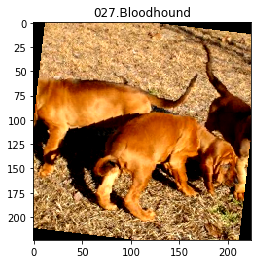

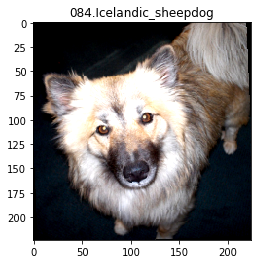

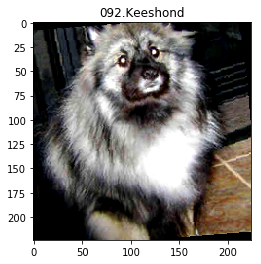

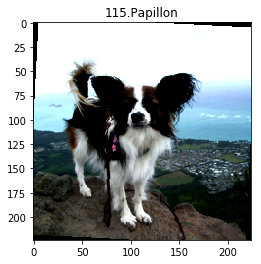

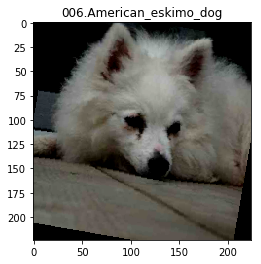

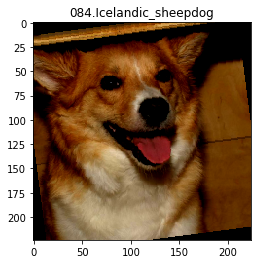

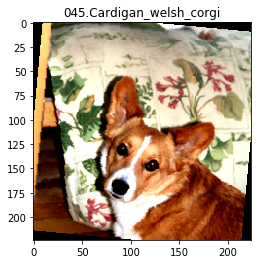

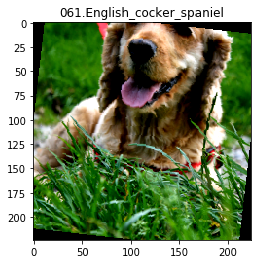

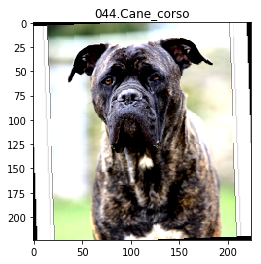

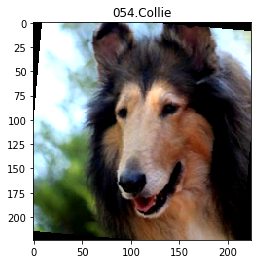

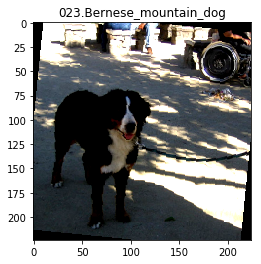

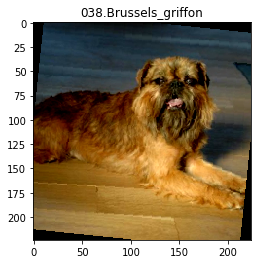

In [79]:
# get training data to explore
inputs, labels = next(iter(loaders_scratch['train']))

for image, label in zip(inputs, labels): # combine inputs and class names
    image = image.to('cpu').clone().detach()
    image = image.numpy().squeeze() # remove single dimension 
    image = image.transpose(1,2,0)
    image = image * np.array((0.3, 0.3, 0.3)) + np.array((0.5, 0.5, 0.5))
    image = image.clip(0,1)
    
    fig = plt.figure(figsize = (8,4))
    plt.imshow(image)
    plt.title(class_names[label])

In [33]:
# Combine all data loaders into a list
loaders_scratch = ['training_scratch', 'validation_scratch', 'test_scratch']

In [34]:
# check to see if data loads
# check shape of the imported data
import numpy as np

img = next(iter(training_scratch))
print(img[0].shape)

# shows batches of 128 pictures of 224 by 224 with 3 channels

torch.Size([128, 3, 224, 224])


**Question 3:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?


**Answer_RTW**: As the current image sizes vary, I wanted to change this to a 224,224,3 dimensions. I've also included some augmentation through center cropping and flipping. I have normalized the channels with a 0.5 mean and 0.2 SD to keep things simple. 

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  Use the template in the code cell below.

In [81]:
# make the model; just 3 conv2D layers for now
# in channels, out channels, kernel size
# changed in channels to 3

import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    ### TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        ## First layer should see (224, 224, 3) shape, matching input images
        self.conv1 = nn.Conv2d(3, 16, 3, padding = 1, stride = 1) # kernel size 3*3
        self.conv2 = nn.Conv2d(16, 32, 3, padding = 1, stride = 1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding = 1, stride = 1)
        self.pool = nn.MaxPool2d(2,2) # max pooling layer with 2*2 kernel
        
        # ensure the right 
        self.fc1 = nn.Linear(64*28*28, 500) # assuming 5 pooling layers, 500 nodes (random choice)
        self.fc2 = nn.Linear(500, 133) # 133 classes of dogs 
        
        self.dropout = nn.Dropout(0.2)
        
        # include batch normalization
        self.batch_norm = nn.BatchNorm1d(num_features = 500)
        
    def forward(self, x):
        ## Define forward behavior
        ## Chosen for intermittent convolution/pooling and dropout layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.dropout(x)
        
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout(x)
        
        x = self.pool(F.relu(self.conv3(x)))
        x = self.dropout(x)
        
        ## flatten for FC layers
        x = x.view(x.size(0), -1) # use x.size(0) to be precise
        
        ## linear layers + additional dropout
        x = F.relu(self.batch_norm(self.fc1(x)))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

#-#-# You so NOT have to modify the code below this line. #-#-#

# instantiate the CNN
# creata an instance of Net()
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer_RTW:__ 

I wanted the model to be simple and easy to modify, with fast increasing depth. Simplicity is in the fact that there is just an alternation between convolutions and pooling layers. I have also just used the relu function to start with.

Additionally - given the complexity of the model - I have used a dropout function to avoid overfitting, and because I believe this plays a major role in 'brain efficiency' in real life. Although it will make the network a bit slower, I hope it will help it generalize better. I have also included batchnorm as best practice to improve performance.

I struggled for a long time with the size; but realized later that the image dimensions would transform from (224,224) to (112,112) to (56,56) to (28,28) given the MaxPool2d layer. To flatten the input I could then combine the depth in that stage of the model (64) with the (28,28) dimensions.

In [83]:
print(model_scratch)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=50176, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=133, bias=True)
  (dropout): Dropout(p=0.2)
  (batch_norm): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and the optimizer as `optimizer_scratch` below.

In [82]:
import torch.optim as optim

### TODO: select loss function
## Use CrossEntropy for multi-class predictions
criterion_scratch = nn.CrossEntropyLoss() 

### TODO: select optimizer
## Use Adam for adaptive learning rate
optimizer_scratch = optim.Adam(model_scratch.parameters(), lr = 0.01)

### (IMPLEMENTATION) Train and Validate the Model (NOT WORKING)

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_scratch.pt'`.

In [84]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    
    valid_loss_min = np.Inf
    
    if os.path.exists(save_path):
        model.load_state_dict(torch.load(save_path))
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for data, target in loaders['train']:
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update training loss
            train_loss += loss.item()*data.size(0)
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for data, target in loaders['valid']:
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
    
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss 
            valid_loss += loss.item()*data.size(0)
            
        # calculate average losses
        train_loss = train_loss/len(loaders['train'].dataset)
        valid_loss = valid_loss/len(loaders['valid'].dataset)
        
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
             # save model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
    # return trained model
    return model

# Training the model - fixed


Try out your model on the test dataset of dog images.  Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 10%.

Note that this NEEDS to run on GPU, otherwise it takes 5-6 hours!

In [86]:
# Actually training the model using the above train function
# Note that this takes 3-4 hours on CPU, so reduced the epochs
model_scratch = train(1, loaders_scratch, model_scratch, optimizer_scratch, criterion_scratch, use_cuda, 'model_scratch.pt')

Epoch: 1 	Training Loss: 4.372917 	Validation Loss: 4.364775
Validation loss decreased (inf --> 4.364775).  Saving model ...


## Test the model - 6% accuracy after one epoch


In [99]:
# define a test function, using the loaders
# should use the model.eval() state
def test(loaders, model, criterion, use_cuda):
    
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        
        # forward 
        output = model(data)
        
        # calculate the loss
        loss = criterion(output, target)
        
        # update average test loss 
        test_loss += loss.item()*data.size(0)
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
        # print testing statistics 
            
    # calculate average loss
    test_loss = test_loss/len(loaders['test'].dataset)
        
    # print 
    print('Testing Loss Average: {:.6f} '.format(test_loss))
    
    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

In [100]:
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Testing Loss Average: 4.360383 

Test Accuracy:  6% (53/836)


## START HERE FOR PART II

---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively). 

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [119]:
## use the loaders built last time
import torch
import torchvision

loaders_transfer = loaders_scratch
print(loaders_transfer)

{'train': <torch.utils.data.dataloader.DataLoader object at 0x12a4c2898>, 'valid': <torch.utils.data.dataloader.DataLoader object at 0x12a4c22b0>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x1288e3128>}


### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify dog breed.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [127]:
# load model VGG16
# note the 1000 output classes, and input size of 4096 for the final layer
model_transfer = models.vgg16(pretrained=True)

if use_cuda:
    VGG16 = VGG16.cuda()
    print('Running on GPU!')
else:
    print('Running on CPU, be aware! \n')

print(model_transfer)

Running on CPU, be aware! 

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_

## Building the model on top of VGG16_features

Note: there are two models below that both need training time. Don't run them all! 

In [129]:
# freeze the params in the features part of the model
for param in model_transfer.features.parameters():
    param.requires_grad = False

# update the last Linear layser in the classifier, use the existing inputs to this layer
model_transfer.classifier[6] = nn.Linear(4096, 133)
if use_cuda:
    model_transfer_1 = model_transfer.cuda()

__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 

I want the VGG16/Resnet50 feature layers to classify the most abstract features in the data in the beginning using transfer learning, and end the code with a simple dense layer (2-3) that can learn to classify the dog breed. In the beginning, I aim to freeze the weights of the earlier layers, to maybe adapt later (unfreeze) if the model needs further tuning. 

Since Resnet is one of the best models (Stanford Benchmark), I also wanted to check Resnet here. 

Note that both VGG and Resnet are trained originally on Imagenet, which has 1000 classes. We have 133, so the final layer should reflect that. 

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/master/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/master/optim.html).  Save the chosen loss function as `criterion_transfer`, and the optimizer as `optimizer_transfer` below.

In [130]:
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.Adam(model_transfer.classifier[6].parameters(), lr = 0.001)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

Note that this takes a long time on CPU, do it on GPU.

In [132]:
# train the model
model_transfer_1 = train(1, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.prt')

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [ ]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by your model.  

In [ ]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item[4:].replace("_", " ") for item in data_transfer['train'].classes]

def predict_breed_transfer(img_path):
    # load the image and return the predicted breed
    return None

---
<a id='step5'></a>
## Step 5: Write your Algorithm - TO DO FROM HERE

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `human_detector` functions developed above.  You are __required__ to use your CNN from Step 4 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [ ]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.

def run_app(img_path):
    ## handle cases for a human face, dog, and neither
    


---
<a id='step6'></a>
## Step 6: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that _you_ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ (Three possible points for improvement)

In [ ]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.

## suggested code, below
for file in np.hstack((human_files[:3], dog_files[:3])):
    run_app(file)